torch.Size([28, 28])


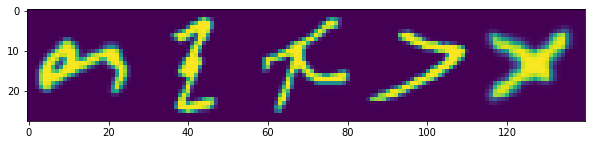

저장 위치:  /content/drive/MyDrive/Colab Notebooks/2023-02-01-14:16


  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


TypeError: ignored

In [ ]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import time


# download path 정의
download_root = '/content/drive/MyDrive/Colab Notebooks' 


class ImageTransform():

    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    def __call__(self, img):
        return self.data_transform(img)

mean = 0.5
std = 1.0

# Dataset download

train_dataset = datasets.EMNIST(download_root, 'letters',transform =ImageTransform(mean, std),download = True)
test_dataset = datasets.EMNIST(download_root, 'letters',transform =ImageTransform(mean, std),download = False)


bs = 100

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)


for i in train_loader:
  plt.figure(figsize=(10,10))
  k = None
  for img in i[0][5:10]:
    img = img.permute(1, 2, 0)
    img = img.squeeze()
    if k == None:
      k = img
      print(k.shape)
    else:
      k = torch.cat((k,img), 1)
  plt.imshow(k)
  break
plt.show()

class VAE(nn.Module):
    def __init__(self, input_dim, hid_dim1, hid_dim2, emb_dim):
        super(VAE, self).__init__()
        
        self.input_dim = input_dim

        # encoder part
        self.fc1 = nn.Linear(input_dim, hid_dim1)
        self.fc2 = nn.Linear(hid_dim1, hid_dim2)
        self.fc3_mean = nn.Linear(hid_dim2, emb_dim)
        self.fc3_var = nn.Linear(hid_dim2, emb_dim)
        # decoder part
        self.fc4 = nn.Linear(emb_dim, hid_dim2)
        self.fc5 = nn.Linear(hid_dim2, hid_dim1)
        self.fc6 = nn.Linear(hid_dim1, input_dim)
        
    def forward(self, x):

        #encoding
        temp = F.relu(self.fc1(x.view(-1, 784)))
        temp = F.relu(self.fc2(temp))
        mu = self.fc3_mean(temp)
        log_var = self.fc3_var(temp)

        #sampling
        std = torch.exp(0.5*log_var) # This is to constrain the variance to be positive (𝜎2∈ℝ+)
                                     # But why learn log_var instead of learning log_sigma,
                                     # which does not require 0.5 multiplication?
        eps = torch.randn_like(std)
        z = eps.mul(std).add_(mu)

        #decoding
        temp = F.relu(self.fc4(z))
        temp = F.relu(self.fc5(temp))
        return F.sigmoid(self.fc6(temp)), mu, log_var
    
# build model
vae = VAE(784, 128, 32, 20)
if torch.cuda.is_available():
    vae.cuda()

optimizer = optim.Adam(vae.parameters())

# return reconstruction error + KL divergence losses
def loss_function(reconstructed_data, original_data, mu, log_var):
    Binary_CE = F.binary_cross_entropy(reconstructed_data, original_data.view(-1, 784), reduction='sum')
    KL_Divergence = -0.5 * torch.sum(1 + log_var - mu**2 - log_var.exp())
    return Binary_CE + KL_Divergence

def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.cuda()        
        optimizer.zero_grad()
        
        reconstructed_data, mu, log_var = vae(data)
        loss = loss_function(reconstructed_data, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.cuda()
            recon, mu, log_var = vae(data)
            
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))


for epoch in range(1, 50):
    train(epoch)
    test()

with torch.no_grad():
    z = torch.randn(32, 20).cuda()
    sample = vae.decoder(z).cuda()
    
    save_image(sample.view(32, 1, 28, 28), '/content/drive/MyDrive/Colab Notebooks' + '.png')




In [ ]:
import shutil

shutil.rmtree('/content/drive/MyDrive/Colab Notebooks/epinions_dataset')

shutil.rmtree('/content/drive/MyDrive/Colab Notebooks/food-101')



In [ ]:
pip install shutil

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement shutil (from versions: none)
ERROR: No matching distribution found for shutil


In [ ]:
pwd

'/content'

In [ ]:
cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks
